# Imaging

This guide will give a quick intro to the `imaging` sub-package in torchbearer. `imaging` is intended to make it easier to handle images that are being produced by callbacks and should be sent to a file or displayed on the screen. We train a Variational Auto-Encoder (VAE) on Street View House Numbers (SVHN) to show how you can create visualisations easily with `imaging`.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


## Loading Data

We first begin by loading in the Street View House Numbers (SVHN) dataset, this may take a while to download.

In [2]:
import torch
import torchvision
from torchvision import transforms

from torchbearer.cv_utils import DatasetValidationSplitter

BATCH_SIZE = 256

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = torchvision.datasets.SVHN(root='./data/svhn', split='train', download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
extra_dataset = torchvision.datasets.SVHN(root='./data/svhn', split='extra', download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), normalize]))
dataset = torch.utils.data.ConcatDataset((dataset, extra_dataset))
splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)


testset = torchvision.datasets.SVHN(root='./data/svhn', split='test', download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize]))
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/extra_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


## A Simple VAE

For this example, we define a simple VAE that will produce images for us to visualise.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

import torchbearer
MU = torchbearer.state_key('mu')
LOGVAR = torchbearer.state_key('logvar')

class VAE(nn.Module):
    def __init__(self, latents):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 32, 16, 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 64, 4, 4
        )
        
        self.mu = nn.Linear(64 * 4 * 4, latents)
        self.logvar = nn.Linear(64 * 4 * 4, latents)
        
        self.z_up = nn.Linear(latents, 64 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),  # 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)  # 3, 32, 32
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, state):
        state[torchbearer.Y_TRUE] = state[torchbearer.INPUT]
        x = self.encoder(x).view(x.size(0), -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        state[MU] = mu
        state[LOGVAR] = logvar
        
        z = self.reparameterize(mu, logvar)
        x = self.z_up(z)
        x = x.view(-1, 64, 4, 4)
        return self.decoder(x)

## Training and Viewing Outputs

We can now train our VAE and view the outputs using an imaging callback, specifically the [`FromState` callback](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.FromState).

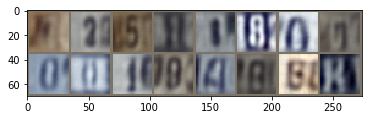

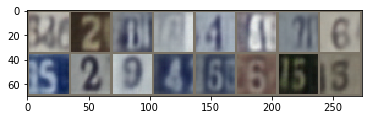

In [5]:
%matplotlib inline
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch.optim as optim
import torchbearer
from torchbearer import Trial, callbacks, metrics
import torchbearer.callbacks.imaging as imaging

KL = torchbearer.state_key('kl')

inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])

model = VAE(32)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = nn.MSELoss(reduction='sum')

@callbacks.add_to_loss
def kl(state):
    mu = state[MU]
    logvar = state[LOGVAR]
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    state[KL] = kl
    return kl

trial = Trial(model, optimizer, loss, metrics=['acc', 'loss', metrics.running_mean(metrics.mean(KL))], callbacks=[
    kl,
    imaging.FromState(torchbearer.Y_PRED, transform=inv_normalize).on_val().cache(16).make_grid().to_pyplot()
]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history = trial.run(epochs=2, verbose=2)

## Custom Imaging Callback

Suppose we now want to define a custom [`ImagingCallback`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.imaging.imaging.ImagingCallback) which performs a particular visualisation, such as random sampling. We can do this by implementing the `on_batch` method, which should yield an image (or batch of images) each step. Here is an example

In [12]:
class RandomSampler(imaging.ImagingCallback):
    def __init__(self, latents, samples=64, transform=None):
        super().__init__(transform=transform)
        self.latents = latents
        self.samples = samples
    
    @callbacks.once_per_epoch
    def on_batch(self, state):
        z = torch.randn(self.samples, self.latents).to(state[torchbearer.DEVICE])
        return state[torchbearer.MODEL].decoder(state[torchbearer.MODEL].z_up(z).view(-1, 64, 4, 4))

With our callback implemented, we can evaluate our model on the test data to see some random samples. We also send our image to a file here using the `to_file` method.

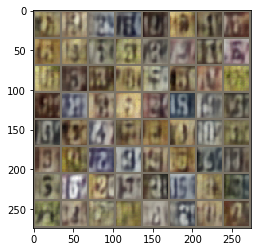

In [15]:
trial = Trial(model, criterion=loss, metrics=['acc', 'loss', metrics.running_mean(metrics.mean(KL))], callbacks=[
    kl,
    RandomSampler(32, transform=inv_normalize).on_test().make_grid().to_pyplot().to_file('samples.png')
]).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
_ = trial.evaluate(data_key=torchbearer.TEST_DATA)